# Analysing NYC High School Data
In this project we will analyse data pertaining the Scholastic Aptitude Test (SAT), a test that high school seniors in the U.S. take every year. Colleges use the SAT to determine which students to admit and high average SAT scores are usually indicative of a good school.

Our dataset consists in SAT statistics made publicly available by New York City. The city is very diverse and has a significant immigrant fraction in its population, and the goal in this mission will be to verify how SAT scores vary (or don't!) following income, gender, ethnic group, etc.

##### NOTE: Cells 1 through 9 came pre-compiled

## Read in the data

In [1]:
import pandas as pd
import numpy as np
import re

data_files = [
    "ap_2010.csv",
    "class_size.csv",
    "demographics.csv",
    "graduation.csv",
    "hs_directory.csv",
    "sat_results.csv"
]

data = {}

for f in data_files:
    d = pd.read_csv("Data/{0}".format(f))
    data[f.replace(".csv", "")] = d

## Read in the surveys

In [2]:
all_survey = pd.read_csv("Data/survey_all.txt", delimiter="\t", encoding='windows-1252')
d75_survey = pd.read_csv("Data/survey_d75.txt", delimiter="\t", encoding='windows-1252')
survey = pd.concat([all_survey, d75_survey], axis=0, sort=False)

survey["DBN"] = survey["dbn"]

survey_fields = [
    "DBN", 
    "rr_s", 
    "rr_t", 
    "rr_p", 
    "N_s", 
    "N_t", 
    "N_p", 
    "saf_p_11", 
    "com_p_11", 
    "eng_p_11", 
    "aca_p_11", 
    "saf_t_11", 
    "com_t_11", 
    "eng_t_11", 
    "aca_t_11", 
    "saf_s_11", 
    "com_s_11", 
    "eng_s_11", 
    "aca_s_11", 
    "saf_tot_11", 
    "com_tot_11", 
    "eng_tot_11", 
    "aca_tot_11",
]
survey = survey.loc[:,survey_fields]
data["survey"] = survey

## Add DBN columns

In [3]:
data["hs_directory"]["DBN"] = data["hs_directory"]["dbn"]

def pad_csd(num):
    string_representation = str(num)
    if len(string_representation) > 1:
        return string_representation
    else:
        return "0" + string_representation
    
data["class_size"]["padded_csd"] = data["class_size"]["CSD"].apply(pad_csd)
data["class_size"]["DBN"] = data["class_size"]["padded_csd"] + data["class_size"]["SCHOOL CODE"]

## Convert columns to numeric

In [4]:
cols = ['SAT Math Avg. Score', 'SAT Critical Reading Avg. Score', 'SAT Writing Avg. Score']
for c in cols:
    data["sat_results"][c] = pd.to_numeric(data["sat_results"][c], errors="coerce")

data['sat_results']['sat_score'] = data['sat_results'][cols[0]] + data['sat_results'][cols[1]] + data['sat_results'][cols[2]]

def find_lat(loc):
    coords = re.findall("\(.+, .+\)", loc)
    lat = coords[0].split(",")[0].replace("(", "")
    return lat

def find_lon(loc):
    coords = re.findall("\(.+, .+\)", loc)
    lon = coords[0].split(",")[1].replace(")", "").strip()
    return lon

data["hs_directory"]["lat"] = data["hs_directory"]["Location 1"].apply(find_lat)
data["hs_directory"]["lon"] = data["hs_directory"]["Location 1"].apply(find_lon)

data["hs_directory"]["lat"] = pd.to_numeric(data["hs_directory"]["lat"], errors="coerce")
data["hs_directory"]["lon"] = pd.to_numeric(data["hs_directory"]["lon"], errors="coerce")

## Condense datasets

In [5]:
class_size = data["class_size"]
class_size = class_size[class_size["GRADE "] == "09-12"]
class_size = class_size[class_size["PROGRAM TYPE"] == "GEN ED"]

class_size = class_size.groupby("DBN").agg(np.mean)
class_size.reset_index(inplace=True)
data["class_size"] = class_size

data["demographics"] = data["demographics"][data["demographics"]["schoolyear"] == 20112012]

data["graduation"] = data["graduation"][data["graduation"]["Cohort"] == "2006"]
data["graduation"] = data["graduation"][data["graduation"]["Demographic"] == "Total Cohort"]

## Convert AP scores to numeric

In [6]:
cols = ['AP Test Takers ', 'Total Exams Taken', 'Number of Exams with scores 3 4 or 5']

for col in cols:
    data["ap_2010"][col] = pd.to_numeric(data["ap_2010"][col], errors="coerce")

## Combine the datasets

In [7]:
combined = data["sat_results"]

combined = combined.merge(data["ap_2010"], on="DBN", how="left")
combined = combined.merge(data["graduation"], on="DBN", how="left")

to_merge = ["class_size", "demographics", "survey", "hs_directory"]

for m in to_merge:
    combined = combined.merge(data[m], on="DBN", how="inner")

combined = combined.fillna(combined.mean())
combined = combined.fillna(0)

## Add a school district column for mapping

In [8]:
def get_first_two_chars(dbn):
    return dbn[0:2]

combined["school_dist"] = combined["DBN"].apply(get_first_two_chars)

## Find correlations

In [9]:
correlations = combined.corr()
correlations = correlations["sat_score"]
print(correlations)

SAT Critical Reading Avg. Score         0.986820
SAT Math Avg. Score                     0.972643
SAT Writing Avg. Score                  0.987771
sat_score                               1.000000
AP Test Takers                          0.523140
Total Exams Taken                       0.514333
Number of Exams with scores 3 4 or 5    0.463245
Total Cohort                            0.325144
CSD                                     0.042948
NUMBER OF STUDENTS / SEATS FILLED       0.394626
NUMBER OF SECTIONS                      0.362673
AVERAGE CLASS SIZE                      0.381014
SIZE OF SMALLEST CLASS                  0.249949
SIZE OF LARGEST CLASS                   0.314434
SCHOOLWIDE PUPIL-TEACHER RATIO               NaN
schoolyear                                   NaN
fl_percent                                   NaN
frl_percent                            -0.722225
total_enrollment                        0.367857
ell_num                                -0.153778
ell_percent         

## Plotting survey correlations
Let's begin by plotting the correlations between SAT Score and the fields contained in the 'survey_all.txt' and 'survey_d75.txt' surveys.

In [10]:
import matplotlib.pyplot as plt
%matplotlib inline

In [11]:
# Remove DBN since it's a unique identifier, not a useful numerical value for correlation.
survey_fields.remove("DBN")

In [77]:
bar_widths = correlations[survey_fields].sort_values(ascending=True)
bar_pos = np.arange(bar_widths.shape[0])
tick_pos = range(bar_widths.shape[0])

Text(0.5,1,'SAT score vs. Survey parameters correlation')

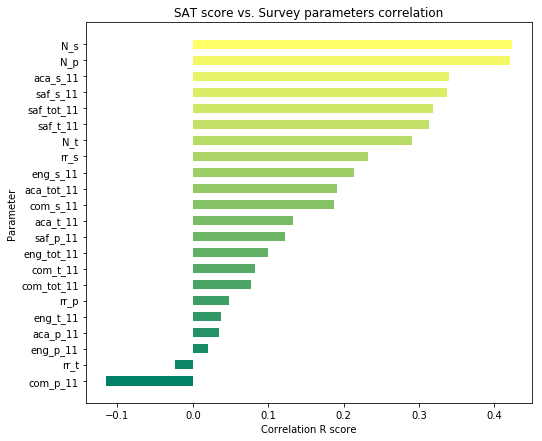

In [78]:
from numpy import linspace
colours = [plt.cm.summer(i) for i in linspace(0,1,len(bar_widths))]
fig, ax = plt.subplots(figsize=(8,7))
ax.barh(bar_pos,bar_widths,0.6,color=colours)
ax.set_yticks(tick_pos)
ax.set_yticklabels(bar_widths.index)
ax.set_xlabel("Correlation R score")
ax.set_ylabel("Parameter")
ax.set_title("SAT score vs. Survey parameters correlation")

### Observations
The SAT scores have a strong positive correlation with the number of parent and student responders (N_p and N_s). High positive correlations with SAT scores were also found for number of teacher respondents (N_t), safety and respect total score (saf_tot_11), safety and respect scores based on teacher and student responses (saf_t_11 and saf_s_11) and academic expectations score based on student responses (aca_s_11).

Let's take a look at 'saf_s_11' directly.

Text(0.5,1,'Safety and Respect Scores (Student responses) vs. SAT Score')

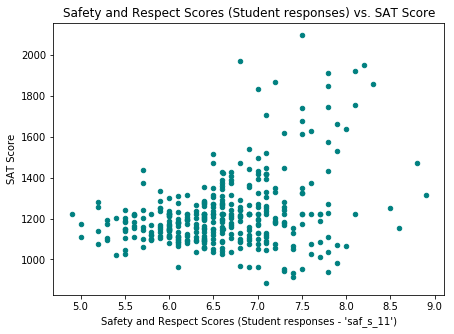

In [50]:
fig, ax = plt.subplots(figsize=(7,5))
combined.plot.scatter(x="saf_s_11",y="sat_score",ax=ax,color="teal")
ax.set_xlabel("Safety and Respect Scores (Student responses - 'saf_s_11')")
ax.set_ylabel("SAT Score")
ax.set_title("Safety and Respect Scores (Student responses) vs. SAT Score")

The high correlation between SAT score and safety and respect score as perceived by students seems driven by a cluster of high-SAT score schools (>1500). 

There are many, many factors we could investigate to find out what distinguishes schools with high safety scores from those with low safety scores. For example, we can calculate average safety scores for each district in New York and look at the geographical distribution of the safety scores.

In [52]:
# Group by districts
districts = combined.groupby("school_dist").agg(np.mean)
districts.reset_index(inplace=True)

In [53]:
from mpl_toolkits.basemap import Basemap

C:\Users\jacop\Anaconda3\lib\site-packages\mpl_toolkits\basemap\__init__.py:1708: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instead.
  limb = ax.axesPatch
C:\Users\jacop\Anaconda3\lib\site-packages\mpl_toolkits\basemap\__init__.py:1711: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instead.
  if limb is not ax.axesPatch:


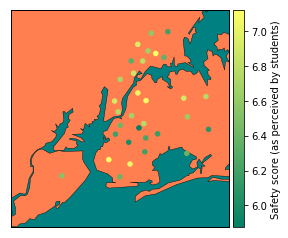

In [69]:
m = Basemap(
    projection='merc', 
    llcrnrlat=40.496044, 
    urcrnrlat=40.915256, 
    llcrnrlon=-74.255735, 
    urcrnrlon=-73.700272,
    resolution='h',
)
m.drawmapboundary(fill_color="teal")
m.drawcoastlines(color="black", linewidth=.4)
m.drawrivers(color="black", linewidth=.4)
m.fillcontinents(color='coral',lake_color='teal')
longitudes = districts["lon"].tolist()
latitudes = districts["lat"].tolist()
m.scatter(longitudes,latitudes,s=20,c=districts["saf_s_11"],cmap="summer",zorder=2,latlon=True)
m.colorbar(label="Safety score (as perceived by students)")

As it turns out, schools are perceived by students as least safe in northern Brooklyn and southern Queens.

## Investigating the correlation between SAT scores and race
As stated in the introduction, New York City is very diverse and has a large immigrant population. What correlation is there between the SAT scores of NYC High Schools and the race of their students?

In [79]:
race_fields = ["white_per","asian_per","black_per","hispanic_per"]
bar_widths = correlations[race_fields]
bar_pos = np.arange(bar_widths.shape[0])
tick_pos = range(bar_widths.shape[0])

Text(0.5,1,'SAT score vs. Race percentage correlation')

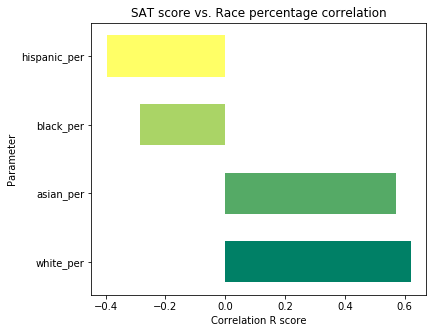

In [81]:
colours = [plt.cm.summer(i) for i in linspace(0,1,len(bar_widths))]
fig, ax = plt.subplots(figsize=(6,5))
ax.barh(bar_pos,bar_widths,0.6,color=colours)
ax.set_yticks(tick_pos)
ax.set_yticklabels(race_fields)
ax.set_xlabel("Correlation R score")
ax.set_ylabel("Parameter")
ax.set_title("SAT score vs. Race percentage correlation")

SAT scores are found to have strong positive correlation with white and asian student presence and negative correlation with black and hispanic student presence.

Let's look at the relationship between SAT scores and the percentage of hispanic students directly through a scatter plot.

Text(0.5,1,'Percentage of hispanic students vs. SAT Score')

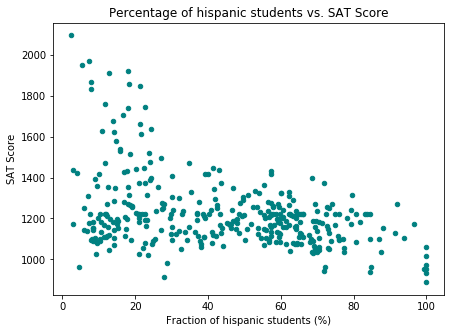

In [82]:
plotme = combined.loc[:,["hispanic_per","sat_score"]]
fig, ax = plt.subplots(figsize=(7,5))
plotme.plot.scatter(x="hispanic_per",y="sat_score",ax=ax,color="teal")
ax.set_xlabel("Fraction of hispanic students (%)")
ax.set_ylabel("SAT Score")
ax.set_title("Percentage of hispanic students vs. SAT Score")

The correlation seems largely driven by a cluster of high-SAT score schools (>1500), with the addition of a small cluster of ~100% hispanic schools with very low SAT scores.

Let's select for the latter and find more information about these schools.

In [83]:
high_hispanic = combined[combined["hispanic_per"] > 95]
high_hispanic

,DBN,SCHOOL NAME,Num of SAT Test Takers,SAT Critical Reading Avg. Score,SAT Math Avg. Score,SAT Writing Avg. Score,sat_score,SchoolName,AP Test Takers,Total Exams Taken,...,Location 1,Community Board,Council District,Census Tract,BIN,BBL,NTA,lat,lon,school_dist
44,02M542,MANHATTAN BRIDGES HIGH SCHOOL,66,336.0,378.0,344.0,1058.0,Manhattan Bridges High School,67.000000,102.000000,...,"525 West 50Th Street\nNew York, NY 10019\n(40....",4.000000,3.000000,135.000000,1.083802e+06,1.010790e+09,Clinton ...,40.765027,-73.992517,02
82,06M348,WASHINGTON HEIGHTS EXPEDITIONARY LEARNING SCHOOL,70,380.0,395.0,399.0,1174.0,0,129.028846,197.038462,...,"511 West 182Nd Street\nNew York, NY 10033\n(40...",12.000000,10.000000,269.000000,1.063703e+06,1.021550e+09,Washington Heights North ...,40.848879,-73.930807,06
89,06M552,GREGORIO LUPERON HIGH SCHOOL FOR SCIENCE AND M...,56,339.0,349.0,326.0,1014.0,GREGORIO LUPERON HS SCI & MATH,88.000000,138.000000,...,"501 West 165Th\nNew York, NY 10032\n(40.838032...",6.792244,22.238227,3760.027701,2.587480e+06,2.515083e+09,0,40.838032,-73.938371,06
125,09X365,ACADEMY FOR LANGUAGE AND TECHNOLOGY,54,315.0,339.0,297.0,951.0,Academy for Language and Technology,20.000000,20.000000,...,"1700 Macombs Road\nBronx, NY 10453\n(40.849102...",5.000000,14.000000,21502.000000,2.008460e+06,2.028660e+09,University Heights-Morris Heights ...,40.849102,-73.916088,09
141,10X342,INTERNATIONAL SCHOOL FOR LIBERAL ARTS,49,300.0,333.0,301.0,934.0,International School for Liberal Arts,55.000000,73.000000,...,"2780 Reservoir Avenue\nBronx, NY 10468\n(40.87...",7.000000,11.000000,409.000000,2.015241e+06,2.032470e+09,Van Cortlandt Village ...,40.870377,-73.898163,10
176,12X388,PAN AMERICAN INTERNATIONAL HIGH SCHOOL AT MONROE,30,321.0,351.0,298.0,970.0,0,129.028846,197.038462,...,"1300 Boynton Avenue\nBronx, NY 10472\n(40.8313...",9.000000,18.000000,56.000000,2.027459e+06,2.038640e+09,West Farms-Bronx River ...,40.831366,-73.878823,12
253,19K583,MULTICULTURAL HIGH SCHOOL,29,279.0,322.0,286.0,887.0,Multicultural High School,44.000000,44.000000,...,"999 Jamaica Avenue\nBrooklyn, NY 11208\n(40.69...",5.000000,37.000000,1180.000000,3.090738e+06,3.040940e+09,park-cemetery-etc-Brooklyn ...,40.691144,-73.868426,19
286,24Q296,PAN AMERICAN INTERNATIONAL HIGH SCHOOL,55,317.0,323.0,311.0,951.0,0,129.028846,197.038462,...,"45 10 94Th Street\nElmhurst, NY 11373\n(40.743...",4.000000,25.000000,463.000000,4.437166e+06,4.016000e+09,Elmhurst ...,40.743303,-73.870575,24


### Observations

After a few web searches, these schools are found to be a mixture of preparatory schools for university and of schools specifically targeted towards hispanic immigrants.

Let's search for information about the cluster of high SAT score schools too.

In [84]:
lo_his_hi_sat = combined[combined["hispanic_per"] < 10]
lo_his_hi_sat = lo_his_hi_sat[lo_his_hi_sat["sat_score"] > 1800]
lo_his_hi_sat

,DBN,SCHOOL NAME,Num of SAT Test Takers,SAT Critical Reading Avg. Score,SAT Math Avg. Score,SAT Writing Avg. Score,sat_score,SchoolName,AP Test Takers,Total Exams Taken,...,Location 1,Community Board,Council District,Census Tract,BIN,BBL,NTA,lat,lon,school_dist
37,02M475,STUYVESANT HIGH SCHOOL,832,679.0,735.0,682.0,2096.0,STUYVESANT HS,1510.0,2819.0,...,"345 Chambers Street\nNew York, NY 10282\n(40.7...",1.0,1.0,31703.0,1084587.0,1.000160e+09,Battery Park City-Lower Manhattan ...,40.717746,-74.014049,02
151,10X445,BRONX HIGH SCHOOL OF SCIENCE,731,632.0,688.0,649.0,1969.0,BRONX HS OF SCIENCE,1190.0,2435.0,...,"75 West 205 Street\nBronx, NY 10468\n(40.87705...",7.0,11.0,409.0,2094706.0,2.032510e+09,Van Cortlandt Village ...,40.877056,-73.889780,10
187,13K430,BROOKLYN TECHNICAL HIGH SCHOOL,1277,587.0,659.0,587.0,1833.0,BROOKLYN TECHNICAL HS,2117.0,3692.0,...,"29 Ft Greene Place\nBrooklyn, NY 11217\n(40.68...",2.0,35.0,33.0,3058752.0,3.020980e+09,Fort Greene ...,40.688107,-73.976745,13
327,28Q687,QUEENS HIGH SCHOOL FOR THE SCIENCES AT YORK CO...,121,612.0,660.0,596.0,1868.0,Queens HS for Science York Colllege,215.0,338.0,...,"94 50 159 Street\nJamaica, NY 11433\n(40.70099...",12.0,27.0,246.0,4215611.0,4.100990e+09,Jamaica ...,40.700999,-73.798154,28
356,31R605,STATEN ISLAND TECHNICAL HIGH SCHOOL,227,635.0,682.0,636.0,1953.0,STATEN ISLAND TECHNICAL HS,528.0,905.0,...,485 Clawson Street Staten Island\nNY 10306\n(4...,2.0,50.0,134.0,5107621.0,5.042440e+09,New Dorp-Midland Beach ...,40.567913,-74.115362,31


### Observations

After a few web searches, these schools are found to be Specialized High Schools, tuition-free public high schools run by the NYC Department of Education for academically and artistically gifted students. The harsh selection required for admission likely produces a natural bias towards high SAT scores.

## Investigating the correlation between SAT scores and gender
We've taken a brief look at the correlation between SAT scores and race of the students. Furthermore, what correlation is there between the SAT scores of NYC High Schools and the gender of their students?

In [95]:
gender_fields = ["male_per","female_per"]
bar_widths = correlations[gender_fields]
bar_pos = np.arange(bar_widths.shape[0])
tick_pos = range(bar_widths.shape[0])

Text(0.5,1,'SAT score vs. Race percentage correlation')

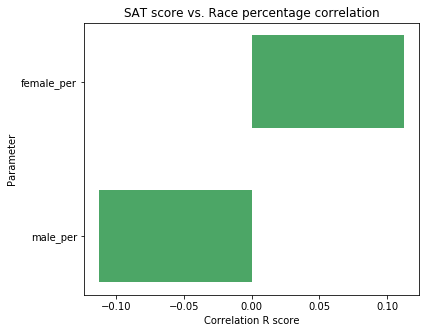

In [97]:
fig, ax = plt.subplots(figsize=(6,5))
ax.barh(bar_pos,bar_widths,0.6,color=plt.cm.summer(.3))
ax.set_yticks(tick_pos)
ax.set_yticklabels(gender_fields)
ax.set_xlabel("Correlation R score")
ax.set_ylabel("Parameter")
ax.set_title("SAT score vs. Race percentage correlation")

The SAT scores are found to have a weak positive correlation with the percentage of female students and a weak negative correlation with the percentage of male students.

As before, let's look at the relationship between SAT Scores and the percentage of female students directly.

Text(0.5,1,'Percentage of female students vs. SAT Score')

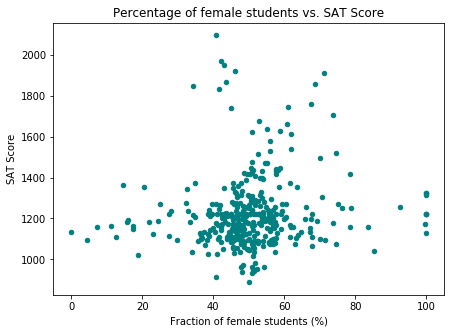

In [90]:
plotme = combined.loc[:,["female_per","sat_score"]]
fig, ax = plt.subplots(figsize=(7,5))
plotme.plot.scatter(x="female_per",y="sat_score",ax=ax,color="teal")
ax.set_xlabel("Fraction of female students (%)")
ax.set_ylabel("SAT Score")
ax.set_title("Percentage of female students vs. SAT Score")

The scatter plot is inconclusive. The cluster of schools with SAT score above 1500 is slightly skewd towards high female student percentages, but the highest scores belong in fact to schools with female fraction < 50%. 

Let's select for High Schools with a large percentage of female students and find more information about these schools.

In [94]:
hi_fem_hi_sat = combined[combined["female_per"] > 60]
hi_fem_hi_sat = hi_fem_hi_sat[hi_fem_hi_sat["sat_score"] > 1600]
hi_fem_hi_sat

,DBN,SCHOOL NAME,Num of SAT Test Takers,SAT Critical Reading Avg. Score,SAT Math Avg. Score,SAT Writing Avg. Score,sat_score,SchoolName,AP Test Takers,Total Exams Taken,...,Location 1,Community Board,Council District,Census Tract,BIN,BBL,NTA,lat,lon,school_dist
5,01M696,BARD HIGH SCHOOL EARLY COLLEGE,130,624.0,604.0,628.0,1856.0,0,129.028846,197.038462,...,"525 East Houston Street\nNew York, NY 10002\n(...",3.0,2.0,1002.0,1004062.0,1.003250e+09,Lower East Side ...,40.718962,-73.976066,01
26,02M416,ELEANOR ROOSEVELT HIGH SCHOOL,127,572.0,594.0,592.0,1758.0,Eleanor Roosevelt High School,155.000000,235.000000,...,"411 East 76 Street\nNew York, NY 10021\n(40.77...",8.0,5.0,132.0,1045949.0,1.014710e+09,Lenox Hill-Roosevelt Island ...,40.770116,-73.953379,02
27,02M418,MILLENNIUM HIGH SCHOOL,144,528.0,553.0,533.0,1614.0,Millennium High School,86.000000,95.000000,...,"75 Broad Street\nNew York, NY 10004\n(40.70492...",1.0,1.0,9.0,1000849.0,1.000290e+09,Battery Park City-Lower Manhattan ...,40.704920,-74.011514,02
60,03M479,BEACON HIGH SCHOOL,261,577.0,575.0,592.0,1744.0,BEACON SCHOOL,166.000000,197.000000,...,"227 243 West 61St Street\nNew York, NY 10023\n...",7.0,6.0,151.0,1030328.0,1.011540e+09,Lincoln Square ...,40.772158,-73.987797,03
61,03M485,FIORELLO H. LAGUARDIA HIGH SCHOOL OF MUSIC & A...,531,566.0,564.0,577.0,1707.0,FIORELLO H.LAGUARDIA HS,691.000000,1236.000000,...,"100 Amsterdam Avenue\nNew York, NY 10023\n(40....",7.0,6.0,151.0,1030341.0,1.011560e+09,Lincoln Square ...,40.773671,-73.985269,03
287,24Q299,BARD HIGH SCHOOL EARLY COLLEGE II,155,545.0,568.0,550.0,1663.0,0,129.028846,197.038462,...,"30 20 Thomson Avenue\nLong Island City, NY 111...",2.0,26.0,179.0,4003517.0,4.002740e+09,Hunters Point-Sunnyside-West Maspeth ...,40.745094,-73.936814,24
302,25Q525,TOWNSEND HARRIS HIGH SCHOOL,278,621.0,651.0,638.0,1910.0,TOWNSEND HARRIS HS,613.000000,796.000000,...,"149 11 Melbourne Avenue\nFlushing, NY 11367\n(...",8.0,24.0,809.0,4538714.0,4.065070e+09,Kew Gardens Hills ...,40.734408,-73.821417,25


### Observations

After a few web searches, all these schools are found to be highly selective, which naturally selects towards SAT scores too. The Fiorello H. LaGuardia schools belongs to the Specialized High Schools group as well.

## Investigating the correlation between SAT scores and % of AP test takers
The Advanced Placement (AP) test is an optional test that High School students in the US take to earn college credit. It would make sense for the number of students taking the AP test to correlate well with  a schools' SAT score. Let's verify this correlation.

In [106]:
# We use the percentage rather than the actual number of test takers because the total number of enrolled students itself
# correlates well with SAT scores and would bias the results.
combined["ap_per"] = combined["AP Test Takers "].divide(combined["total_enrollment"])

Text(0.5,1,'Fraction of AP test takers vs. SAT Score')

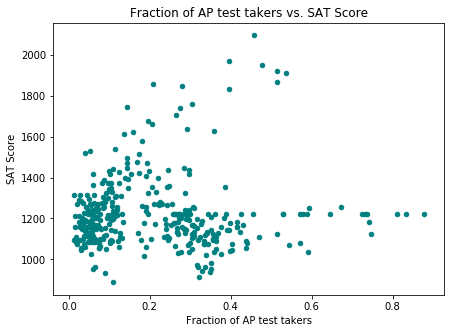

In [107]:
plotme = combined.loc[:,["ap_per","sat_score"]]
fig, ax = plt.subplots(figsize=(7,5))
plotme.plot.scatter(x="ap_per",y="sat_score",ax=ax,color="teal")
ax.set_xlabel("Fraction of AP test takers")
ax.set_ylabel("SAT Score")
ax.set_title("Fraction of AP test takers vs. SAT Score")

The distribution looks bi-modal, with one group of schools with very high numbers of AP test takers but SAT scores around 1200, and one group of schools with high SAT scores (>1500) and mid-low numbers of AP test takers. 

In [102]:
hi_ap_per_lo_sat = combined[combined["ap_per"] > .6]
hi_ap_per_lo_sat

,DBN,SCHOOL NAME,Num of SAT Test Takers,SAT Critical Reading Avg. Score,SAT Math Avg. Score,SAT Writing Avg. Score,sat_score,SchoolName,AP Test Takers,Total Exams Taken,...,Community Board,Council District,Census Tract,BIN,BBL,NTA,lat,lon,school_dist,ap_per
6,02M047,47 THE AMERICAN SIGN LANGUAGE AND ENGLISH SECO...,16,395.000000,400.000000,387.000000,1182.000000,0,129.028846,197.038462,...,6.0,2.0,64.0,2.587480e+06,2.515083e+09,Gramercy ...,40.738599,-73.982512,02,0.741545
31,02M427,MANHATTAN ACADEMY FOR ARTS & LANGUAGE,s,404.119403,419.656716,399.662687,1223.438806,0,129.028846,197.038462,...,5.0,2.0,72.0,1.087537e+06,1.008898e+09,Murray Hill-Kips Bay ...,40.746106,-73.981010,02,0.737308
33,02M438,INTERNATIONAL HIGH SCHOOL AT UNION SQUARE,s,404.119403,419.656716,399.662687,1223.438806,0,129.028846,197.038462,...,6.0,2.0,50.0,1.017828e+06,1.008720e+09,Gramercy ...,40.735519,-73.987604,02,0.733118
50,02M605,HUMANITIES PREPARATORY ACADEMY,36,426.000000,403.000000,426.000000,1255.000000,0,129.028846,197.038462,...,4.0,3.0,89.0,1.013096e+06,1.007420e+09,Hudson Yards-Chelsea-Flatiron-Union Square ...,40.742888,-74.002127,02,0.672025
83,06M423,HIGH SCHOOL FOR EXCELLENCE AND INNOVATION,s,404.119403,419.656716,399.662687,1223.438806,0,129.028846,197.038462,...,12.0,10.0,291.0,1.076776e+06,1.022330e+09,Marble Hill-Inwood ...,40.866046,-73.924857,06,0.724881
111,08X432,BRONX BRIDGES HIGH SCHOOL,s,404.119403,419.656716,399.662687,1223.438806,0,129.028846,197.038462,...,9.0,18.0,16.0,2.022205e+06,2.036040e+09,Soundview-Castle Hill-Clason Point-Harding Par...,40.822304,-73.855961,08,0.832444
208,14K632,FRANCES PERKINS ACADEMY,12,382.000000,372.000000,368.000000,1122.000000,0,129.028846,197.038462,...,1.0,33.0,517.0,3.066698e+06,3.026700e+09,North Side-South Side ...,40.722643,-73.952583,14,0.745831
222,16K688,THE BROOKLYN ACADEMY OF GLOBAL FINANCE,s,404.119403,419.656716,399.662687,1223.438806,0,129.028846,197.038462,...,3.0,36.0,291.0,3.043822e+06,3.016160e+09,Stuyvesant Heights ...,40.691538,-73.933726,16,0.811502
321,28Q325,HILLSIDE ARTS & LETTERS ACADEMY,s,404.119403,419.656716,399.662687,1223.438806,0,129.028846,197.038462,...,8.0,24.0,452.0,4.448806e+06,4.098580e+09,Briarwood-Jamaica Hills ...,40.713577,-73.796518,28,0.645144
335,29Q326,CAMBRIA HEIGHTS ACADEMY,s,404.119403,419.656716,399.662687,1223.438806,0,129.028846,197.038462,...,12.0,23.0,480.0,4.222072e+06,4.104430e+09,Jamaica ...,40.711818,-73.771192,29,0.877747


## Investigating the correlation between SAT scores and % of AP test takers
Class size is widely perceived to adversely affect performance as it grows larger - the idea being that large classes are more chaotic and are generally difficult for teachers to handle. Let's verify if this holds true within our data.

Text(0.5,1,'Average class size vs. SAT Score')

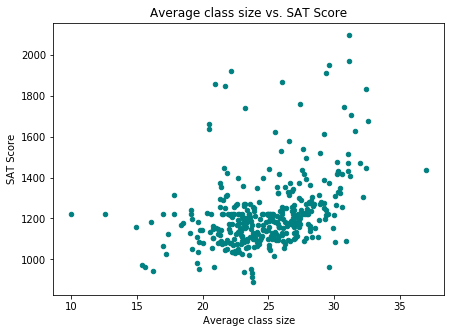

In [108]:
plotme = combined.loc[:,["AVERAGE CLASS SIZE","sat_score"]]
fig, ax = plt.subplots(figsize=(7,5))
plotme.plot.scatter(x="AVERAGE CLASS SIZE",y="sat_score",ax=ax,color="teal")
ax.set_xlabel("Average class size")
ax.set_ylabel("SAT Score")
ax.set_title("Average class size vs. SAT Score")

As it turns out, small average class sizes correlate negatively with high SAT scores! The best schools (SAT score-wise) have an average class size between 20 and 33 students.